In [1]:
import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer
import numpy as np
import re
import requests
import validators
from urllib.parse import urlparse
import matplotlib
import matplotlib.pyplot as plt

# Step 1: Gathering Data

In [2]:
#read the data from 
import pandas as pd
df_archive =pd.read_csv("twitter-archive-enhanced-2.csv", index_col = 'tweet_id')
unclean_archive = df_archive.copy()

In [3]:
import json
useful_data = []
with open('tweet_json.txt') as f:
      for line in f:
        line= json.loads(line)
        #print(line.keys())
        #break
        dic= {"tweet_id": line["id"],  "retweet_count": line["retweet_count"], "likes_count": line["favorite_count"]}
        useful_data.append(dic)
df_API = pd.DataFrame(useful_data).set_index('tweet_id')
unclean_API = df_API.copy()

In [4]:
df_predictions = pd.read_csv("image-predictions-3.tsv", sep='\t',index_col ='tweet_id')
unclean_predictions = df_predictions.copy()

# Step 2: Assessement

## Issues Found

<font size="3">
    
<b>Structure:</b>

- The dog's stage is known from searching the four columns(doggo,floofer,pupper,puppo). This causes the columns to have many null values. Those 4 stages should be combined.
- Each of the prediction and confidence columns can be merged into one based on the p-(1,2,3)_dog value.
- All useful data should be grouped in a unified dataset. Also, non-useful data should be neglected.

<b>Quality:</b>

- Change the timestamp format from string to datetime format. 
    
- Rating is not reasonable; so, I need to make the values something out of 10.

- Some dog names were retrieved incorrectly; for example, while checking the value_counts, I found dogs named 'a'. This should be changed such that there is a dog name of NaN.
    
- There are duplicates in the data. The duplicates should be removed.

- Some hyperlinks don't exist. They should be replaced with NaN.

- Ignore non-orignal retweets. Hence, 
    retweeted_status_id, retweeted_status_user_id should be None.
    in_reply_to_status_id, in_reply_to_user_id should be None.
    Replies and retweets are non-original.
    
- In some columns, the value is NaN; in others it is None. This should be unified to NaN.

- The source column is not readable. Instead of a link, it should be a string of the useful value.
    
</font> 


In [5]:
df_archive.head()

,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
tweet_id,,,,,,,,,,,,,,,,
892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [6]:
df_archive.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 892420643555336193 to 666020888022790149
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   in_reply_to_status_id       78 non-null     float64
 1   in_reply_to_user_id         78 non-null     float64
 2   timestamp                   2356 non-null   object 
 3   source                      2356 non-null   object 
 4   text                        2356 non-null   object 
 5   retweeted_status_id         181 non-null    float64
 6   retweeted_status_user_id    181 non-null    float64
 7   retweeted_status_timestamp  181 non-null    object 
 8   expanded_urls               2297 non-null   object 
 9   rating_numerator            2356 non-null   int64  
 10  rating_denominator          2356 non-null   int64  
 11  name                        2356 non-null   object 
 12  doggo                       2356 non-null   object 
 13  fl

In [7]:
#check the value counts of each column
df_archive['doggo'].value_counts()

None     2259
doggo      97
Name: doggo, dtype: int64

In [8]:
df_archive.describe()

,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [9]:
df_API.head()

,retweet_count,likes_count
tweet_id,,
892420643555336193,7454,35302
892177421306343426,5535,30552
891815181378084864,3660,22993
891689557279858688,7624,38592
891327558926688256,8220,36878


In [10]:
df_API.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2330 entries, 892420643555336193 to 666020888022790149
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   retweet_count  2330 non-null   int64
 1   likes_count    2330 non-null   int64
dtypes: int64(2)
memory usage: 54.6 KB


In [11]:
df_predictions.head()

,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
tweet_id,,,,,,,,,,,
666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [12]:
df_predictions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2075 entries, 666020888022790149 to 892420643555336193
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   jpg_url  2075 non-null   object 
 1   img_num  2075 non-null   int64  
 2   p1       2075 non-null   object 
 3   p1_conf  2075 non-null   float64
 4   p1_dog   2075 non-null   bool   
 5   p2       2075 non-null   object 
 6   p2_conf  2075 non-null   float64
 7   p2_dog   2075 non-null   bool   
 8   p3       2075 non-null   object 
 9   p3_conf  2075 non-null   float64
 10  p3_dog   2075 non-null   bool   
dtypes: bool(3), float64(3), int64(1), object(4)
memory usage: 152.0+ KB


In [13]:
df_predictions['p2_dog'].value_counts()

True     1553
False     522
Name: p2_dog, dtype: int64

# Step 3: Clean Data

<font size="4">
I will solve some of the problems mentioned above:
</font>

## First, Quality Issues

In [14]:
#1
#string to datetime format - 2017-08-01 16:23:56 +0000
format_str = "%Y-%m-%d %H:%M:%S %z"
df_archive ['timestamp']= pd.to_datetime(df_archive['timestamp'], format= format_str)
#check
df_archive['timestamp'].dtype

datetime64[ns, UTC]

In [15]:
#2
#Unify the None values to be NaN
df_archive.replace("None", np.nan, inplace= True)
#check
df_archive['doggo'].value_counts() 

doggo    97
Name: doggo, dtype: int64

In [16]:
#3
#Dogs names are not retrieved correctly (name: a, an,...) -> Fix
df_archive.drop(df_archive[df_archive.name.str.len() <= 2].index, inplace=True)
#check
fil = (df_archive['name'].str.len() <= 2) 
df_archive.loc[fil]

,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
tweet_id,,,,,,,,,,,,,,,,


In [17]:
#4
#Make the source links readable
df_archive['source'] = df_archive['source'].apply(lambda x: re.findall(r'>(.*)<', x)[0])
#check
df_archive['source'].value_counts()

Twitter for iPhone     2147
Vine - Make a Scene      91
Twitter Web Client       30
TweetDeck                 9
Name: source, dtype: int64

In [18]:
df_archive.head(2)

,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
tweet_id,,,,,,,,,,,,,,,,
892420643555336193,NaN,NaN,2017-08-01 16:23:56+00:00,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,NaN,NaN,NaN,NaN
892177421306343426,NaN,NaN,2017-08-01 00:17:27+00:00,Twitter for iPhone,This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,NaN,NaN,NaN,NaN


In [19]:
def check_url(x):
    x = str(x)
    try:
        result = urlparse(x)
        #print(x)
        return x
    except:
        return np.nan

In [20]:
#5
#some links in expanded_urls can not exist; they should be removed
df_archive['expanded_urls'] = df_archive['expanded_urls'].apply(lambda x: check_url(x))
#remove nan 
df_archive.replace("nan", np.nan, inplace= True)
df_archive.head(2)

,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
tweet_id,,,,,,,,,,,,,,,,
892420643555336193,NaN,NaN,2017-08-01 16:23:56+00:00,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,NaN,NaN,NaN,NaN
892177421306343426,NaN,NaN,2017-08-01 00:17:27+00:00,Twitter for iPhone,This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,NaN,NaN,NaN,NaN


## Second, Structure Issues:

In [21]:
#6
#The fact that the dogs' names are put in 4 different columns, there exists alot of none values
#Hence, Those 4 columns can be combined (Melted) together
melt_columns = ['doggo', 'floofer', 'pupper', 'puppo']
stay_columns = [x for x in df_archive.columns.tolist() if x not in melt_columns]

df_archive = pd.melt(df_archive, id_vars = stay_columns, value_vars = melt_columns, 
                         var_name = 'stages', value_name = 'life_stage',ignore_index=False)
df_archive = df_archive.drop('stages', 1)
df_archive['life_stage'].value_counts()

pupper     251
doggo       95
puppo       30
floofer     10
Name: life_stage, dtype: int64

In [22]:
df_archive.head()

,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,life_stage
tweet_id,,,,,,,,,,,,,
892420643555336193,NaN,NaN,2017-08-01 16:23:56+00:00,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,NaN
892177421306343426,NaN,NaN,2017-08-01 00:17:27+00:00,Twitter for iPhone,This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,NaN
891815181378084864,NaN,NaN,2017-07-31 00:18:03+00:00,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,NaN
891689557279858688,NaN,NaN,2017-07-30 15:58:51+00:00,Twitter for iPhone,This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,NaN
891327558926688256,NaN,NaN,2017-07-29 16:00:24+00:00,Twitter for iPhone,This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,NaN


In [23]:
#7
#In df_predictions, the p1,p1_conf......etc should be merged
p = []
conf = []
#gather the predictions and the confidences in two lists
def prediction_confidence(df):
    if df['p1_dog'] == True:
        p.append(df['p1'])
        conf.append(df['p1_conf'])
        
    elif df['p2_dog'] == True:
        p.append(df['p2'])
        conf.append(df['p2_conf'])
        
    elif df['p3_dog'] == True:
        p.append(df['p3'])
        conf.append(df['p3_conf'])
        
    else:
        p.append(np.nan)
        conf.append(0)

In [24]:
df_predictions.apply(prediction_confidence, axis=1)
df_predictions['prediction'] = p
df_predictions['confidence'] = conf

In [25]:
#remove p1,p2,p3,p1_conf,p2_dog,...etc from the dataframe as we do not need them anymore
#img_num is always 1 and is not needed; so, we can remove it from the data
df_predictions = df_predictions.drop(['img_num', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf',
                                                           'p2_dog', 'p3', 'p3_conf', 'p3_dog'], 1)

In [26]:
df_predictions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2075 entries, 666020888022790149 to 892420643555336193
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   jpg_url     2075 non-null   object 
 1   prediction  1751 non-null   object 
 2   confidence  2075 non-null   float64
dtypes: float64(1), object(2)
memory usage: 64.8+ KB


In [27]:
df_archive.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9108 entries, 892420643555336193 to 666020888022790149
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   in_reply_to_status_id       312 non-null    float64            
 1   in_reply_to_user_id         312 non-null    float64            
 2   timestamp                   9108 non-null   datetime64[ns, UTC]
 3   source                      9108 non-null   object             
 4   text                        9108 non-null   object             
 5   retweeted_status_id         708 non-null    float64            
 6   retweeted_status_user_id    708 non-null    float64            
 7   retweeted_status_timestamp  708 non-null    object             
 8   expanded_urls               8872 non-null   object             
 9   rating_numerator            9108 non-null   int64              
 10  rating_denominator          9

In [28]:
#Remove the retweets & replies from df_archive
df_archive = df_archive[pd.isnull(df_archive.retweeted_status_id)]
df_archive = df_archive[pd.isnull(df_archive.in_reply_to_status_id)]

# Delete the columns that are not needed
df_archive = df_archive.drop('retweeted_status_id', 1)
df_archive = df_archive.drop('retweeted_status_user_id', 1)
df_archive = df_archive.drop('retweeted_status_timestamp', 1)

df_archive = df_archive.drop('in_reply_to_status_id', 1)
df_archive = df_archive.drop('in_reply_to_user_id', 1)

# Delete duplicated data
df_archive = df_archive.drop_duplicates()

In [29]:
#8
#Modify the ratings to be more reasonable
#df_archive['rating_numerator'].value_counts()

In [30]:
#df_archive['rating_denominator'].value_counts()

In [31]:
#remove outliners 
#Most of the rating_denominator = 10
#Most of the rating_numerator < 12
df_archive = df_archive[df_archive["rating_denominator"] == 10]
df_archive = df_archive[df_archive["rating_numerator"] <= 12]

In [32]:
#df_archive['rating_numerator'].value_counts()
#df_API.info()
df_archive.head(2)

,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,life_stage
tweet_id,,,,,,,,
891815181378084864,2017-07-31 00:18:03+00:00,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,NaN
891327558926688256,2017-07-29 16:00:24+00:00,Twitter for iPhone,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,NaN


In [33]:
#Combine all the data into one unified dataframe
df_archive_clean = df_archive.join(df_API,how='inner')

In [34]:
df_archive_clean = df_archive_clean.join(df_predictions,how='inner')

In [35]:
df_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1837 entries, 666020888022790149 to 891815181378084864
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   timestamp           1837 non-null   datetime64[ns, UTC]
 1   source              1837 non-null   object             
 2   text                1837 non-null   object             
 3   expanded_urls       1837 non-null   object             
 4   rating_numerator    1837 non-null   int64              
 5   rating_denominator  1837 non-null   int64              
 6   name                1323 non-null   object             
 7   life_stage          246 non-null    object             
 8   retweet_count       1837 non-null   int64              
 9   likes_count         1837 non-null   int64              
 10  jpg_url             1837 non-null   object             
 11  prediction          1552 non-null   object             
 12  con

In [36]:
#Save cleaned data
df_archive_clean.to_csv("twitter_archive_master.csv")
df_predictions.to_csv("complete_predictions.csv")

# Analysis and Visualizations

In [37]:
# insight 1: The most common dog type the dataset
dog = df_archive_clean['prediction'].value_counts().idxmax()
occurances= df_archive_clean['prediction'].value_counts().max()
print(f"The most common dog type is:\n{dog} with {occurances} total occurrences.")

The most common dog type is:
golden_retriever with 143 total occurrences.


In [38]:
# Insight_ 2 : average rating for each stage
tmp = df_archive_clean.groupby ('life_stage')
means= tmp.mean()["rating_numerator"]
print(f" The mean ratings for each stage:\n {round(means.doggo,2)} out of 10 for doggos,{round(means.pupper,2)} for puppers, {round(means.puppo,2)} for puppos, and {round(means.floofer,2)} for floofers.")

 The mean ratings for each stage:
 10.89 out of 10 for doggos,10.34 for puppers, 11.08 for puppos, and 11.2 for floofers.


Text(0.5, 1.0, 'Relation between the ratings and the number of likes recieved')

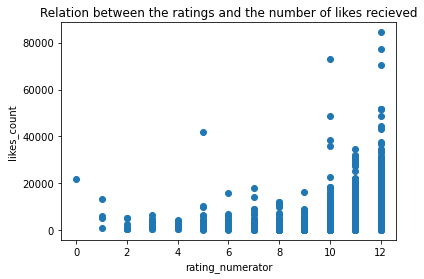

In [39]:
# Insight_ 3 : relation between likes_count and the rating_numerator
plt.scatter(df_archive_clean['rating_numerator'], df_archive_clean['likes_count'])
plt.xlabel('rating_numerator')
plt.ylabel('likes_count')
plt.title('Relation between the ratings and the number of likes recieved')

#As expected, people tend to give higher ratings and likes concurrently

Text(0.5, 1.0, 'Relation between the ratings and the number of retweets recieved')

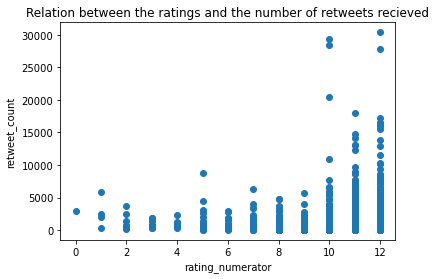

In [40]:
# Insight_ 4 : relation between retweet_count and the rating_numerator
plt.scatter(df_archive_clean['rating_numerator'], df_archive_clean['retweet_count'])
plt.xlabel('rating_numerator')
plt.ylabel('retweet_count')
plt.title('Relation between the ratings and the number of retweets recieved')

(-1.2740067842031575,
 1.1994344530597723,
 -1.2727058400152258,
 1.21277249431261)

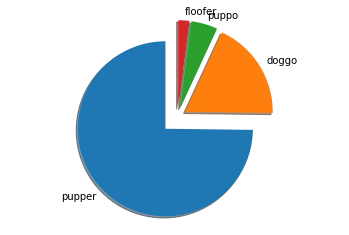

In [41]:
#most common life stage
life_stage_count = list(df_archive_clean[df_archive_clean['life_stage'] != 'None']['life_stage'].value_counts())[0:4]
life_stages = df_archive_clean[df_archive_clean['life_stage'] != np.nan]['life_stage'].value_counts().index.tolist()[0:4]
explode = (0.2, 0.1, 0.1, 0.1) 

figure1, axis1 = plt.subplots()
axis1.pie(life_stage_count, explode = explode, labels = life_stages, shadow = True, startangle = 90)
axis1.axis('equal')